In [ ]:
# 필요한 라이브러리 설치
!pip install datasets torch torchvision scikit-learn matplotlib
!git clone https://github.com/HRNet/HRNet-Image-Classification
%cd HRNet-Image-Classification
!pip install -r requirements.txt
%cd ..

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, random_split
import torchvision.transforms as transforms
from datasets import load_dataset
import numpy as np
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, recall_score, precision_score
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import random
from sklearn.model_selection import KFold
sys.path.append('HRNet-Image-Classification/lib')
from models.cls_hrnet import get_cls_net

In [ ]:
# 재현성을 위한 시드 설정
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# 데이터셋 로드
print("테스트 데이터셋 로드 중...")
test_dataset = load_dataset("espada105/augmented-brain-tumor-segmentation-v2", split="test")
print("학습 데이터셋 로드 중...")
train_dataset = load_dataset("dwb2023/brain-tumor-image-dataset-semantic-segmentation", split="train")
train_valid_dataset = train_dataset.train_test_split(test_size=0.2, seed=42)
train = train_valid_dataset["train"]
valid = train_valid_dataset["test"]

# 추가적인 데이터 분리 - 테스트 데이터셋에서 일부만 사용
# 오버피팅 방지를 위해 테스트 데이터의 일부만 선택
test_indices = list(range(len(test_dataset)))
random.shuffle(test_indices)
test_subset_size = min(len(test_dataset) // 2, 200)  # 50% 또는 최대 200개만 사용
test_subset_indices = test_indices[:test_subset_size]
test = test_dataset.select(test_subset_indices)

print("\n데이터셋 구조 확인:")
print("Train 데이터셋 크기:", len(train))
print("Valid 데이터셋 크기:", len(valid))
print("Test 데이터셋 크기:", len(test))

print("\nTrain 샘플 키:", list(train[0].keys()))
print("Test 샘플 키:", list(test[0].keys()))

# 이미지 전처리 파이프라인 - 더 강력한 증강 적용
transform_train = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Lambda(lambda x: x.convert('RGB') if x.mode != 'RGB' else x),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 테스트용 변환 - 변경 없음
test_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.Lambda(lambda x: x.convert('RGB') if x.mode != 'RGB' else x),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# 커스텀 데이터셋 클래스
class BrainTumorDataset(Dataset):
    def __init__(self, dataset, transform=None, is_test=False):
        self.dataset = dataset
        self.transform = transform
        self.is_test = is_test

        # 데이터셋 구조 확인 후 레이블 키 결정
        self.label_key = None
        if is_test:
            if "category_id" in self.dataset[0]:
                self.label_key = "category_id"
            else:
                print("테스트 데이터셋에서 레이블 키를 찾을 수 없습니다.")
        else:
            if "label" in self.dataset[0]:
                self.label_key = "label"
            elif "category_id" in self.dataset[0]:
                self.label_key = "category_id"
            else:
                print("학습 데이터셋에서 레이블 키를 찾을 수 없습니다.")

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        image = self.dataset[idx]["image"]

        # 각 데이터셋의 레이블 구조에 따라 처리
        if self.label_key is None:
            # 레이블 키를 찾지 못한 경우
            label = 1  # 기본값
        elif self.is_test:
            # espada105 데이터셋 (1=Tumor, 2=Normal)
            label = self.dataset[idx][self.label_key]
        else:
            # dwb2023 데이터셋 처리
            if self.label_key == "label":
                # 문자열 레이블인 경우 (예: "tumor", "normal")
                label_str = self.dataset[idx][self.label_key]
                label = 1 if label_str.lower() == "tumor" else 2  # tumor=1, normal=2
            else:
                # 숫자형 category_id인 경우
                label = self.dataset[idx][self.label_key]

        if self.transform:
            image = self.transform(image)

        return image, torch.tensor(label, dtype=torch.float32)

# 데이터 로더 생성 (배치 사이즈 수정)
batch_size = 32  # 배치 사이즈를 더 크게 설정
train_data = BrainTumorDataset(train, transform=transform_train)
valid_data = BrainTumorDataset(valid, transform=test_transform)
test_data = BrainTumorDataset(test, transform=test_transform, is_test=True)

# 데이터 샘플링 - 클래스 불균형 처리
# 각 클래스의 샘플 수 확인
def count_classes(dataset):
    labels = []
    for i in range(len(dataset)):
        _, label = dataset[i]
        labels.append(label.item())
    unique, counts = np.unique(labels, return_counts=True)
    return dict(zip(unique, counts))

train_class_counts = count_classes(train_data)
print("학습 데이터 클래스 분포:", train_class_counts)

# 클래스 가중치 계산
class_weights = {}
total_samples = sum(train_class_counts.values())
for cls, count in train_class_counts.items():
    class_weights[cls] = total_samples / (len(train_class_counts) * count)

weights = [class_weights[train_data[i][1].item()] for i in range(len(train_data))]
sampler = torch.utils.data.WeightedRandomSampler(weights, len(weights), replacement=True)

# 데이터 로더 생성 (샘플러 적용)
train_loader = DataLoader(train_data, batch_size=batch_size, sampler=sampler, pin_memory=True,
                          drop_last=True)  # drop_last=True로 설정하여 마지막 불완전한 배치 제거
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, pin_memory=True,
                         drop_last=True)  # BatchNorm 오류 방지를 위해 여기도 설정
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, pin_memory=True)


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.4/491.4 kB 12.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 31.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 20.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 42.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/814 [00:00<?, ?B/s]

train-00000-of-00004.parquet:   0%|          | 0.00/408M [00:00<?, ?B/s]

train-00001-of-00004.parquet:   0%|          | 0.00/407M [00:00<?, ?B/s]

train-00002-of-00004.parquet:   0%|          | 0.00/404M [00:00<?, ?B/s]

train-00003-of-00004.parquet:   0%|          | 0.00/407M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/234M [00:00<?, ?B/s]

valid-00000-of-00001.parquet:   0%|          | 0.00/462M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/7510 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/1075 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/2145 [00:00<?, ? examples/s]

학습 데이터셋 로드 중...


README.md:   0%|          | 0.00/6.22k [00:00<?, ?B/s]

(…)-00000-of-00001-1d7ef230dfbdad78.parquet:   0%|          | 0.00/113M [00:00<?, ?B/s]

(…)-00000-of-00001-0031debf8df4462b.parquet:   0%|          | 0.00/16.3M [00:00<?, ?B/s]

(…)-00000-of-00001-bce5cef16a5cce11.parquet:   0%|          | 0.00/32.2M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/1502 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/215 [00:00<?, ? examples/s]

Generating valid split:   0%|          | 0/429 [00:00<?, ? examples/s]


데이터셋 구조 확인:
Train 데이터셋 크기: 1201
Valid 데이터셋 크기: 301
Test 데이터셋 크기: 200

Train 샘플 키: ['file_name', 'image', 'id', 'category_id', 'bbox', 'segmentation', 'area', 'iscrowd', 'height', 'width', 'date_captured', 'license']
Test 샘플 키: ['id', 'file_name', 'image', 'category_id', 'bbox', 'area', 'segmentation', 'iscrowd', 'license']
학습 데이터 클래스 분포: {np.float64(1.0): np.int64(623), np.float64(2.0): np.int64(578)}
HRNet-W18-C-Small-v1 모델 생성 완료 (GroupNorm 적용)
사용 디바이스: cuda


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(



Epoch 1/20
Train Loss: 0.1001 | Val F1: 0.7349 | Val Recall: 0.9859
Val Precision: 0.5858 | Val IoU: 0.5809 | Val AUC: 0.8968
Optimal threshold: 0.70
New best model saved with AUC: 0.8968

Epoch 2/20
Train Loss: 0.0765 | Val F1: 0.8391 | Val Recall: 0.9366
Val Precision: 0.7600 | Val IoU: 0.7228 | Val AUC: 0.8905
Optimal threshold: 0.50
EarlyStopping counter: 1 out of 5

Epoch 3/20
Train Loss: 0.0671 | Val F1: 0.8415 | Val Recall: 0.9718
Val Precision: 0.7419 | Val IoU: 0.7263 | Val AUC: 0.8991
Optimal threshold: 0.30
New best model saved with AUC: 0.8991

Epoch 4/20
Train Loss: 0.0708 | Val F1: 0.8693 | Val Recall: 0.9366
Val Precision: 0.8110 | Val IoU: 0.7688 | Val AUC: 0.9170
Optimal threshold: 0.40
New best model saved with AUC: 0.9170

Epoch 5/20
Train Loss: 0.0606 | Val F1: 0.8726 | Val Recall: 0.9648
Val Precision: 0.7965 | Val IoU: 0.7740 | Val AUC: 0.9401
Optimal threshold: 0.30
New best model saved with AUC: 0.9401

Epoch 6/20
Train Loss: 0.0398 | Val F1: 0.8764 | Val Recal

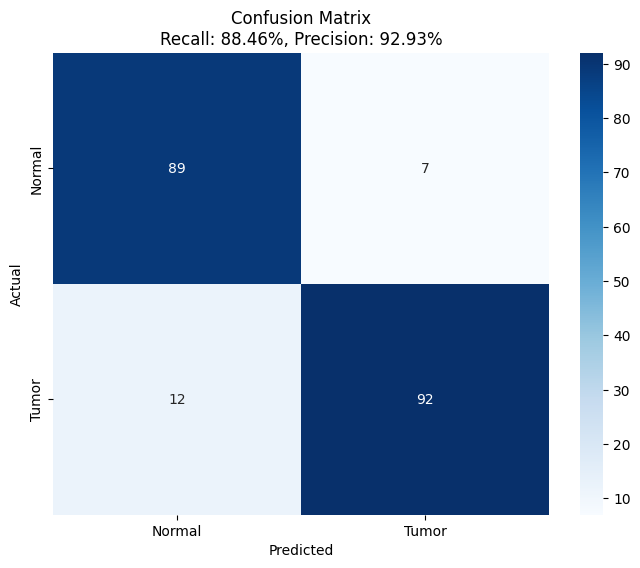

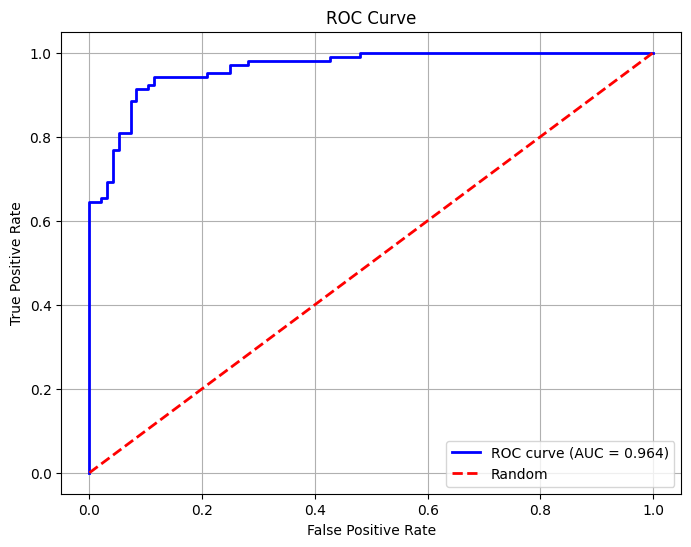

In [ ]:

# HRNet-W18-C-Small-v1 모델 구성
hrnet_config = {
    'MODEL': {
        'NAME': 'cls_hrnet_w18_small_v1',
        'EXTRA': {
            'STAGE1': {
                'NUM_MODULES': 1,
                'NUM_BRANCHES': 1,
                'BLOCK': 'BOTTLENECK',
                'NUM_BLOCKS': [2],
                'NUM_CHANNELS': [64],
                'FUSE_METHOD': 'SUM'
            },
            'STAGE2': {
                'NUM_MODULES': 1,
                'NUM_BRANCHES': 2,
                'BLOCK': 'BASIC',
                'NUM_BLOCKS': [2, 2],
                'NUM_CHANNELS': [18, 36],
                'FUSE_METHOD': 'SUM'
            },
            'STAGE3': {
                'NUM_MODULES': 3,
                'NUM_BRANCHES': 3,
                'BLOCK': 'BASIC',
                'NUM_BLOCKS': [2, 2, 2],
                'NUM_CHANNELS': [18, 36, 72],
                'FUSE_METHOD': 'SUM'
            },
            'STAGE4': {
                'NUM_MODULES': 2,
                'NUM_BRANCHES': 4,
                'BLOCK': 'BASIC',
                'NUM_BLOCKS': [2, 2, 2, 2],
                'NUM_CHANNELS': [18, 36, 72, 144],
                'FUSE_METHOD': 'SUM'
            }
        },
        'NUM_CLASSES': 1000
    }
}

# BatchNorm 문제 해결을 위해 Group Normalization 사용
class HRNetWithGroupNorm(nn.Module):
    def __init__(self, base_model, dropout_rate=0.6):
        super(HRNetWithGroupNorm, self).__init__()
        self.base_model = base_model

        # 마지막 레이어 수정 - BatchNorm 대신 GroupNorm 사용
        input_features = self.base_model.classifier.in_features

        self.classifier = nn.Sequential(
            nn.Linear(input_features, 512),
            nn.GroupNorm(32, 512),  # BatchNorm 대신 GroupNorm 사용 (32개 그룹)
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(512, 256),
            nn.GroupNorm(16, 256),  # BatchNorm 대신 GroupNorm 사용 (16개 그룹)
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(256, 1)
        )

        # 기존 분류기 대체
        self.base_model.classifier = nn.Identity()

    def forward(self, x):
        features = self.base_model(x)
        return self.classifier(features)

# 모델 초기화 및 정규화 적용
base_model = get_cls_net(hrnet_config)
model = HRNetWithGroupNorm(base_model, dropout_rate=0.6)
print("HRNet-W18-C-Small-v1 모델 생성 완료 (GroupNorm 적용)")

# Focal Loss 정의 (클래스 불균형 대응)
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.75, gamma=2.5, eps=1e-6):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.eps = eps

    def forward(self, inputs, targets):
        BCE_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction='none')
        pt = torch.exp(-BCE_loss)
        pt = torch.clamp(pt, self.eps, 1.0 - self.eps)  # NaN 방지
        loss = self.alpha * (1 - pt) ** self.gamma * BCE_loss
        return loss.mean()

# 학습 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"사용 디바이스: {device}")
model = model.to(device)

# L1, L2 정규화를 모두 적용한 옵티마이저
criterion = FocalLoss(alpha=0.75, gamma=2.5)
optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5, weight_decay=1e-3)  # 더 강한 가중치 감쇠
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

# Gradient Clipping 함수
def clip_gradient(optimizer, grad_clip):
    for group in optimizer.param_groups:
        for param in group['params']:
            if param.grad is not None:
                param.grad.data.clamp_(-grad_clip, grad_clip)

# 조기 종료 설정
class EarlyStopping:
    def __init__(self, patience=5, min_delta=0.001, verbose=True):
        self.patience = patience
        self.min_delta = min_delta
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False

    def __call__(self, val_score):
        if self.best_score is None:
            self.best_score = val_score
            return False

        if val_score < self.best_score + self.min_delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                return True
        else:
            self.best_score = val_score
            self.counter = 0
            return False

# 학습 루프
num_epochs = 20  # 더 많은 에포크 (조기 종료 사용)
best_val_auc = 0
grad_clip = 0.5  # 더 작은 그래디언트 클리핑 값
early_stopping = EarlyStopping(patience=5)

for epoch in range(num_epochs):
    model.train()
    train_loss = 0.0
    total_samples = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(images)

        # 레이블 변환: 2(Normal)→0, 1(Tumor)→1
        labels_binary = torch.where(labels == 1, 1.0, 0.0)

        # 출력 차원 조정
        loss = criterion(outputs.squeeze(1), labels_binary)

        loss.backward()
        clip_gradient(optimizer, grad_clip)
        optimizer.step()

        train_loss += loss.item() * images.size(0)
        total_samples += images.size(0)

    train_loss /= total_samples

    # 검증 단계
    model.eval()
    val_probs, val_labels = [], []
    with torch.no_grad():
        for images, labels in valid_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)

            # 확실한 차원 처리
            probs = torch.sigmoid(outputs.squeeze(1)).cpu().numpy()
            val_probs.extend(probs)
            val_labels.extend(labels.cpu().numpy())

    # 레이블 변환
    val_labels_binary = np.where(np.array(val_labels) == 1, 1, 0)

    # 다양한 임계값에서 성능 확인
    thresholds = [0.3, 0.4, 0.5, 0.6, 0.7]
    best_threshold = 0.5
    best_val_f1 = 0

    for threshold in thresholds:
        val_preds = (np.array(val_probs) > threshold).astype(int)
        val_f1 = f1_score(val_labels_binary, val_preds)

        if val_f1 > best_val_f1:
            best_val_f1 = val_f1
            best_threshold = threshold

    # 최적의 임계값으로 예측
    val_preds = (np.array(val_probs) > best_threshold).astype(int)

    # 평가 지표 계산
    val_f1 = f1_score(val_labels_binary, val_preds)
    val_recall = recall_score(val_labels_binary, val_preds)
    val_precision = precision_score(val_labels_binary, val_preds)
    val_auc = roc_auc_score(val_labels_binary, val_probs)
    tn, fp, fn, tp = confusion_matrix(val_labels_binary, val_preds, labels=[0, 1]).ravel()
    val_iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0.0

    print(f"\nEpoch {epoch+1}/{num_epochs}")
    print(f"Train Loss: {train_loss:.4f} | Val F1: {val_f1:.4f} | Val Recall: {val_recall:.4f}")
    print(f"Val Precision: {val_precision:.4f} | Val IoU: {val_iou:.4f} | Val AUC: {val_auc:.4f}")
    print(f"Optimal threshold: {best_threshold:.2f}")

    # 학습률 스케줄러 업데이트
    scheduler.step(val_auc)

    # 최고 모델 저장
    if val_auc > best_val_auc:
        best_val_auc = val_auc
        torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'optimizer_state_dict': optimizer.state_dict(),
            'loss': train_loss,
            'auc': val_auc,
            'threshold': best_threshold
        }, 'best_model.pth')
        print(f"New best model saved with AUC: {val_auc:.4f}")

    # 조기 종료 확인
    if early_stopping(val_auc):
        print("조기 종료 - 성능 향상 없음")
        break

# 테스트 평가
print("\n최고 모델 로딩 중...")
try:
    checkpoint = torch.load('best_model.pth', map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    best_threshold = checkpoint.get('threshold', 0.5)
    print(f"최고 모델 로드 완료 (Epoch {checkpoint['epoch']+1}, Val AUC: {checkpoint['auc']:.4f}, Threshold: {best_threshold:.2f})")
except Exception as e:
    print(f"체크포인트 로딩 실패: {e}")
    print("현재 모델 상태로 평가를 진행합니다.")
    best_threshold = 0.5

print("테스트 데이터셋 평가 중...")
model.eval()

test_probs, test_labels = [], []
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        test_probs.extend(torch.sigmoid(outputs.squeeze(1)).cpu().numpy())
        test_labels.extend(labels.cpu().numpy())

# 레이블 변환
test_labels_binary = np.where(np.array(test_labels) == 1, 1, 0)
test_preds = (np.array(test_probs) > best_threshold).astype(int)

# 평가 지표 계산
test_f1 = f1_score(test_labels_binary, test_preds)
test_recall = recall_score(test_labels_binary, test_preds)
test_precision = precision_score(test_labels_binary, test_preds)
test_auc = roc_auc_score(test_labels_binary, test_probs)
tn, fp, fn, tp = confusion_matrix(test_labels_binary, test_preds, labels=[0, 1]).ravel()
test_iou = tp / (tp + fp + fn) if (tp + fp + fn) > 0 else 0.0

# 최종 결과 출력
print("\n=== 최종 테스트 성능 ===")
print(f"F1-score: {test_f1:.4f}")
print(f"Recall (Tumor): {test_recall:.4f} [TP:{tp}/FN:{fn}]")
print(f"Precision (Tumor): {test_precision:.4f} [TP:{tp}/FP:{fp}]")
print(f"IoU (Tumor): {test_iou:.4f}")
print(f"ROC-AUC: {test_auc:.4f}")
print(f"사용된 임계값: {best_threshold:.2f}")

# 혼동 행렬 시각화
conf_mat = confusion_matrix(test_labels_binary, test_preds, labels=[0, 1])
plt.figure(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Normal','Tumor'],
            yticklabels=['Normal','Tumor'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title(f'Confusion Matrix\nRecall: {test_recall:.2%}, Precision: {test_precision:.2%}')
plt.savefig('confusion_matrix.png')  # 이미지 파일로 저장
plt.show()

# ROC 곡선 플로팅
from sklearn.metrics import roc_curve
fpr, tpr, _ = roc_curve(test_labels_binary, test_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, 'b-', linewidth=2, label=f'ROC curve (AUC = {test_auc:.3f})')
plt.plot([0, 1], [0, 1], 'r--', linewidth=2, label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc='lower right')
plt.grid(True)
plt.savefig('roc_curve.png')
plt.show()